# What happens if we multiply one term by $\alpha$ ?

In [67]:
import numpy as np
import pandas as pd
import xarray as xr
import pyproj
from rasterio.transform import Affine

import dask.dataframe as dd
import matplotlib.pyplot as plt
import matplotlib.colors as cl

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo
crs = ccrs.PlateCarree()
import cmocean.cm as cm

from xgcm import Grid
from xhistogram.xarray import histogram
import warnings
warnings.filterwarnings("ignore")

import os
from glob import glob

import histlib.box as box
import histlib.aviso as aviso
import histlib.cstes as cstes
import histlib.diagnosis as diag
from histlib.cstes import labels, zarr_dir, matchup_dir

In [68]:
if True:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster(cores=56, processes=28, walltime='04:00:00')
    #cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    cluster = PBSCluster(cores=5, processes=5, walltime='02:00:00')
    w = cluster.scale(jobs=4)
    #w = cluster.scale(jobs=3)
else:
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster()

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.65:35617/status,
Dashboard: http://10.148.0.65:35617/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.65:58939,Workers: 0
Dashboard: http://10.148.0.65:35617/status,Total threads: 0
Started: Just now,Total memory: 0 B


# Preparation

In [69]:
alpha = 1.5
tm = 'wd'

In [70]:
zarrs = glob(os.path.join('/home/datawork-lops-osi/aponte/margot/historical_coloc_ok/coloc_err', '*'))

In [71]:
df = dd.concat([pd.read_csv(z) for z in zarrs])

In [72]:
df = df.compute()

In [73]:
len(df)

1896241

In [74]:
dl = 5000
df["distbin"] = (df.alti___distance // dl) * dl

In [75]:
df = df.rename(columns = {'aviso_alti_ggx_adt':'ggx', 
          'aviso_drifter_ggx_adt':'ggxd', 
           'drifter_acc_x_25':'acc',
           'drifter_coriolis_x_25':'cor',
           'es_cstrio_z15_drifter_wd_x':'wd',
          })[['obs','acc','cor','drogue_status','ggx','ggxd','wd','alti___distance','alti___time_difference','lat','lon','time','distbin']]

In [76]:
dfm = df.copy()
dfm[tm] = dfm[tm]*alpha

In [77]:
df['da'] = (df.ggx - df.ggxd)#ggx diff
df['sd']  = df.acc + df.cor + df.ggxd + df.wd #seq (no coloc error)
df['s']  = df.acc + df.cor + df.ggx + df.wd #s with colocation error

var = ['acc', 'cor', 'ggx', 'wd']
vard = ['acc', 'cor', 'ggxd', 'wd']

# Correlation with ggx diff
for v in var : 
    df[v+'da'] = df.da*df[v]
df['ggxdda'] = df.da*df.ggxd

df['sda'] = df['da']*df['s']
df['sdda'] = df['da']*df['sd']

df2 = df[[v for v in df if v not in['obs','drogue_status','alti___distance','alti___time_difference','lat','lon','time','distbin' ]]]**2 # mean square values
df2['distbin'] =df['distbin']

In [78]:
dfm['da'] = (dfm.ggx - dfm.ggxd)#ggx diff
dfm['sd']  = dfm.acc + dfm.cor + dfm.ggxd + dfm.wd #seq (no coloc error)
dfm['s']  = dfm.acc + dfm.cor + dfm.ggx + dfm.wd #s with colocation error

var = ['acc', 'cor', 'ggx', 'wd']
vard = ['acc', 'cor', 'ggxd', 'wd']

# Correlation with ggx diff
for v in var : 
    dfm[v+'da'] = dfm.da*dfm[v]
dfm['ggxdda'] = dfm.da*dfm.ggxd

dfm['sda'] = dfm['da']*dfm['s']
dfm['sdda'] = dfm['da']*dfm['sd']

dfm2 = dfm[[v for v in dfm if v not in['obs','drogue_status','alti___distance','alti___time_difference','lat','lon','time','distbin' ]]]**2 # mean square values
dfm2['distbin'] =dfm['distbin']

In [79]:
from itertools import combinations
comb = list(combinations(var, 2))
combd = list(combinations(vard, 2))
for c in comb :
    df[f'{c[0]}_{c[1]}'] = df[c[0]]*df[c[1]]
    dfm[f'{c[0]}_{c[1]}'] = dfm[c[0]]*dfm[c[1]]
for c in combd :
    df[f'{c[0]}_{c[1]}'] = df[c[0]]*df[c[1]]
    dfm[f'{c[0]}_{c[1]}'] = dfm[c[0]]*dfm[c[1]]

In [80]:
df_ = df.where(df.alti___distance<25000).dropna()
df2_ = df2.where(df.alti___distance<25000).dropna()
print(len(df_))

238662


In [81]:
dfm_ = dfm.where(dfm.alti___distance<25000).dropna()
dfm2_ = dfm2.where(dfm.alti___distance<25000).dropna()
print(len(dfm_))

238662


____________

# We compare two reconstructions (with no colocalisation errors) :

$$a_1 + a_2 + a_3 + a_4 = s$$
$$a_1 + \alpha a_2 + a_3 + a_4 = s_\alpha$$

# $S_{\alpha}$
$$S_{\alpha} - S = \alpha^2 A_2 - A_2 + 2\alpha\sum_{j\neq2}\langle a_2 a_j \rangle -2\sum_{j\neq2}\langle a_2 a_j \rangle$$
$$S_{\alpha} - S = (\alpha^2 -1)A_2+ 2(\alpha -1)\sum_{j\neq2}\langle a_2 a_j \rangle $$

# $E_{i\alpha}$
- Pour $i\neq2$ : $E_{i \alpha}-E_i = (\alpha -1)\langle a_i a_2 \rangle $
- Pour $i=2$ : $E_{2 \alpha}-E_2 = (\alpha^2 -1)A_2 + (\alpha-1)\sum_{j\neq2}\langle a_2 a_j \rangle$

# $B_{i\alpha}$
- Pour $i\neq2$ : $B_{i \alpha}-B_i = (1-\alpha)\langle a_i a_2 \rangle $
- Pour $i=2$ : $B_{2 \alpha}-B_2 = (\alpha-1)B_2 $

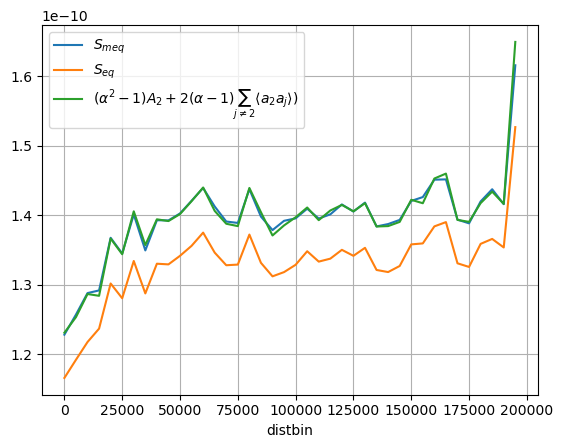

In [82]:
dfm2.groupby("distbin").sd.mean().plot(label = r'$S_{meq}$')

df2.groupby("distbin").sd.mean().plot(label = r'$S_{eq}$')
(df2.groupby("distbin").sd.mean()+ (alpha**2-1)*df2.groupby("distbin")[tm].mean()
 +2*(alpha-1)*df[[f'{c[0]}_{c[1]}' for c in combd if tm in f'{c[0]}_{c[1]}']].sum(axis=1).mean()).plot(label = r'$(\alpha^2 -1)A_2+ 2(\alpha -1)\sum_{j\neq2}\langle a_2 a_j \rangle)$')
plt.legend()
plt.grid()

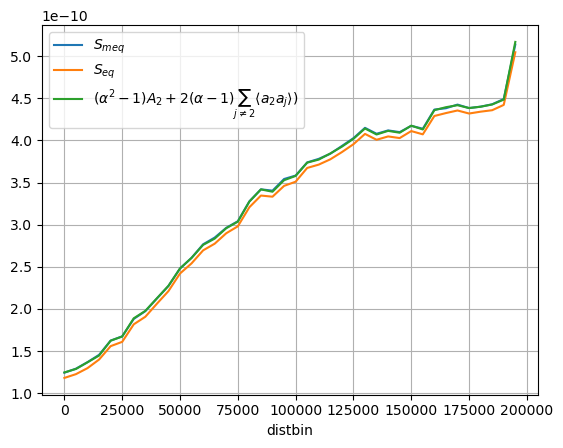

In [97]:
dfm2.groupby("distbin").s.mean().plot(label = r'$S_{meq}$')

df2.groupby("distbin").s.mean().plot(label = r'$S_{eq}$')
(df2.groupby("distbin").s.mean()+ (alpha**2-1)*df2.groupby("distbin")[tm].mean()
 +2*(alpha-1)*df[[f'{c[0]}_{c[1]}' for c in combd if tm in f'{c[0]}_{c[1]}']].sum(axis=1).mean()).plot(label = r'$(\alpha^2 -1)A_2+ 2(\alpha -1)\sum_{j\neq2}\langle a_2 a_j \rangle)$')
plt.legend()
plt.grid()

In [83]:
[f'{c[0]}_{c[1]}' for c in combd if tm in f'{c[0]}_{c[1]}']

['acc_wd', 'cor_wd', 'ggxd_wd']

In [84]:
df_['sdda'].mean()/df2_['da'].mean()

-0.16065589403047326

In [85]:
df_['sdda'].mean()/df2_['sd'].mean()

-0.02134367357869633

In [86]:
df

,obs,acc,cor,drogue_status,ggx,ggxd,wd,alti___distance,alti___time_difference,lat,...,sdda,acc_cor,acc_ggx,acc_wd,cor_ggx,cor_wd,ggx_wd,acc_ggxd,cor_ggxd,ggxd_wd
0,5,0.000001,-0.000002,True,0.000002,0.0,-0.000002,9757.0,114.0,19.56126,...,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0
1,8,0.000001,-0.000006,True,-0.000008,0.000011,-0.000003,66385.0,1028.0,-52.286098,...,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0
2,12,0.000001,0.000017,True,0.000001,0.000006,-0.000004,76832.0,1013.0,-53.251492,...,-0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0
3,15,0.000009,-0.000002,True,0.000003,-0.000003,-0.000002,137980.0,1059.0,18.744101,...,0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0
4,18,-0.00003,0.000023,True,-0.000023,-0.000007,0.000007,178146.0,621.0,50.993561,...,0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5869,11737,0.000004,0.000034,True,-0.000042,-0.00004,0.000002,21375.0,824.0,41.58786,...,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0
5870,11738,-0.000006,0.000057,True,-0.000052,-0.00003,-0.000003,32192.0,162.0,-53.305771,...,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0
5871,11739,-0.000003,0.000011,True,-0.000003,0.000003,-0.000001,33041.0,219.0,-49.834911,...,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
5872,11740,0.000001,-0.000017,True,-0.000005,-0.000002,-0.000002,102417.0,1629.0,20.603239,...,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0


____________
____________
# $B_i$

In [87]:
for v in var :
    df['b_'+v] = -df[[f'{c[0]}_{c[1]}' for c in comb if v in f'{c[0]}_{c[1]}']].sum(axis=1)
    dfm['b_'+v] = -dfm[[f'{c[0]}_{c[1]}' for c in comb if v in f'{c[0]}_{c[1]}']].sum(axis=1)

for v in vard :
    df['bd_'+v] = -df[[f'{c[0]}_{c[1]}' for c in combd if v in f'{c[0]}_{c[1]}']].sum(axis=1)
    dfm['bd_'+v] = -dfm[[f'{c[0]}_{c[1]}' for c in combd if v in f'{c[0]}_{c[1]}']].sum(axis=1)

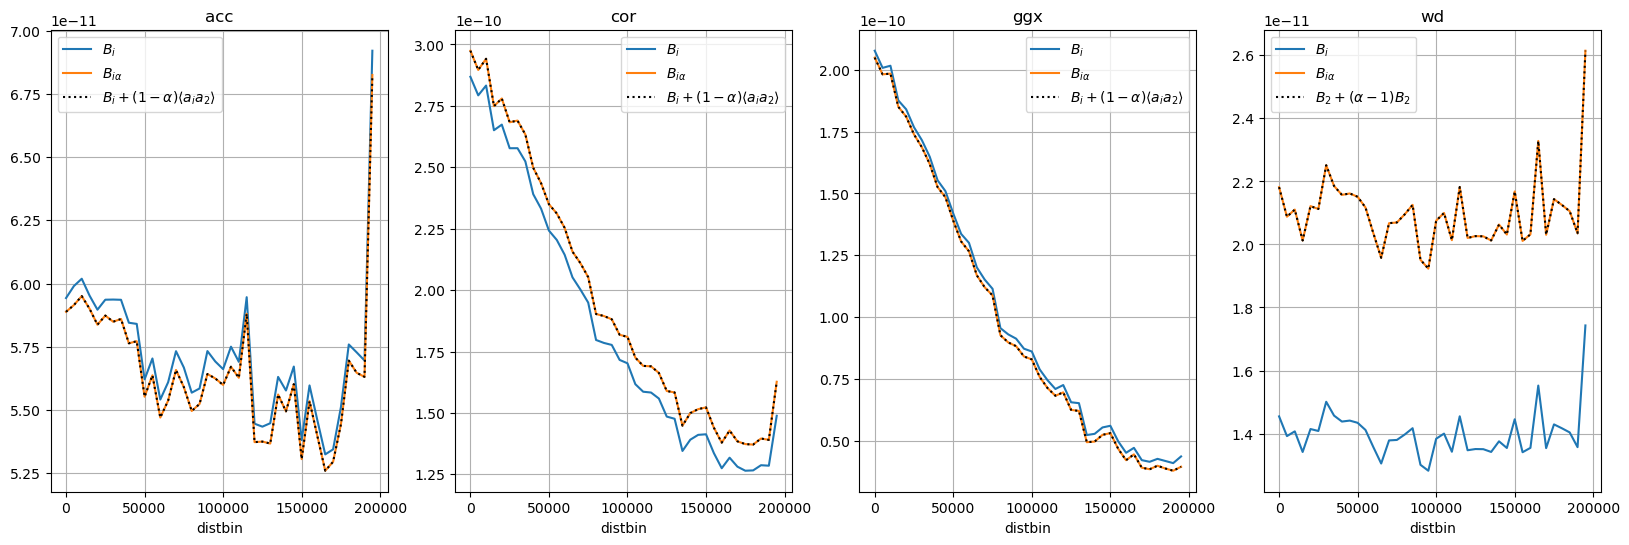

In [93]:
fig, axs = plt.subplots(1, 4,figsize=(20,6))
axs = axs.flatten()
for i in range(len(var)):
    ax = axs[i]
    v = var[i]
    df.groupby("distbin")['b_'+v].mean().plot(label=r'$B_i$', ax=ax)
    dfm.groupby("distbin")['b_'+v].mean().plot(label=r'$B_{i\alpha}$', ax=ax)
    prod = [f'{c[0]}_{c[1]}' for c in comb if (tm in f'{c[0]}_{c[1]}' ) & (v in f'{c[0]}_{c[1]}')][0]
    if v != tm:
        (df.groupby("distbin")['b_'+v].mean() + (1-alpha)*df.groupby("distbin")[prod].mean()).plot(label=r'$B_i + (1-\alpha)\langle a_i a_2 \rangle$', ax=ax, c='k', ls=':')
    else : 
       ((alpha)*df.groupby("distbin")['b_'+v].mean()).plot(label=r'$B_2 + (\alpha-1)B_2$', ax=ax, c='k', ls=':')
    ax.grid()
    ax.set_title(v)
    ax.legend()

# $E_i$

In [94]:
for v in var :
    df[v+'s'] =  df[v] * df['s']
    dfm[v+'s'] =  dfm[v] * dfm['s']

for v in vard :
    df[v+'sd'] =  df[v] * df['sd']
    dfm[v+'sd'] =  dfm[v] * dfm['sd']


df['sumb'] = df[['b_'+v for v in var]].sum(axis=1)
df['sumbd'] = df[['bd_'+v for v in vard]].sum(axis=1)
df['sume'] = df[[v+'s' for v in var]].sum(axis=1)
df['sumed'] = df[[v+'sd' for v in vard]].sum(axis=1)

df_ = df.where(df.alti___distance<25000).dropna()
df2_ = df2.where(df.alti___distance<25000).dropna()

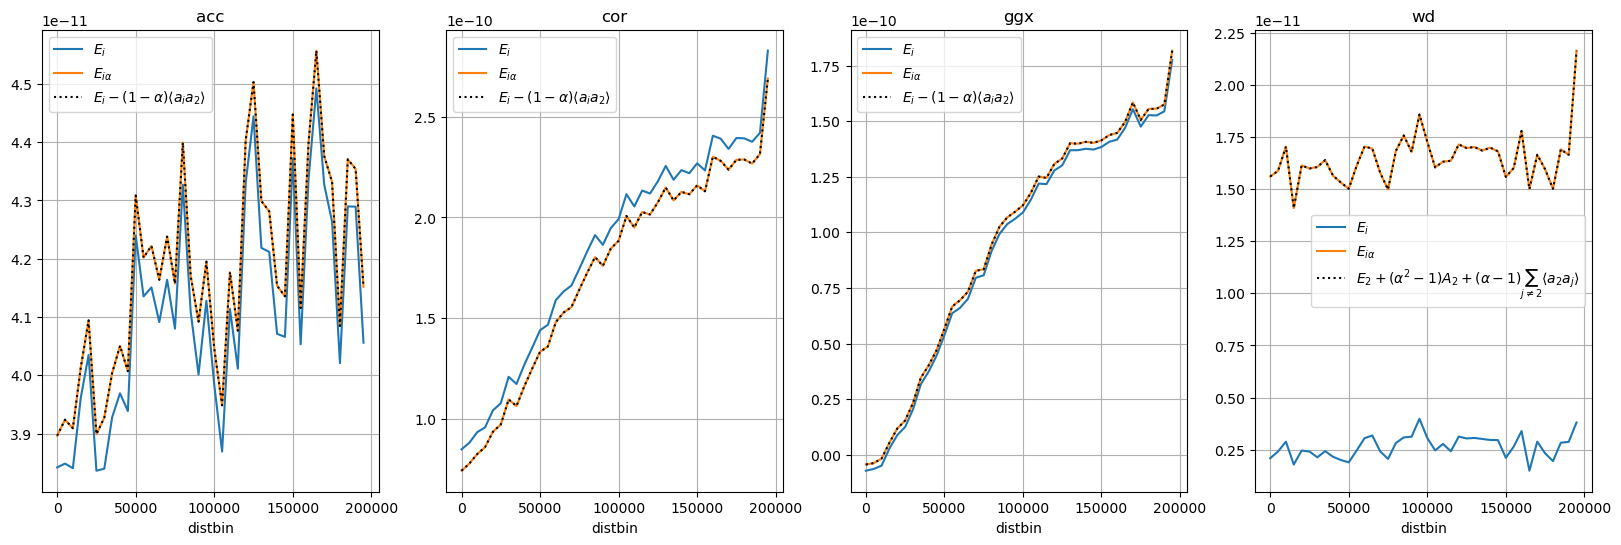

In [96]:
fig, axs = plt.subplots(1, 4,figsize=(20,6))
axs = axs.flatten()
for i in range(len(var)):
    ax = axs[i]
    v, vd = var[i], vard[i]
    df.groupby("distbin")[v+'s'].mean().plot(label=r'$E_i$', ax=ax)
    dfm.groupby("distbin")[v+'s'].mean().plot(label=r'$E_{i\alpha}$', ax=ax)
    prod = [f'{c[0]}_{c[1]}' for c in comb if (tm in f'{c[0]}_{c[1]}' ) & (v in f'{c[0]}_{c[1]}')][0]
    if v!= tm:
        (df.groupby("distbin")[v+'s'].mean() + (alpha-1)*df.groupby("distbin")[prod].mean()).plot(label=r'$E_{i} - (1-\alpha)\langle a_i a_2 \rangle$', ax=ax, c='k', ls=':')
    else:
        ((alpha**2-1)*df2.groupby("distbin")[tm].mean() + (alpha-1)*df.groupby("distbin")[[f'{c[0]}_{c[1]}' for c in comb if tm in f'{c[0]}_{c[1]}']].mean().sum(axis=1)+ df.groupby("distbin")[v+'s'].mean()).plot(label=r'$E_2 + (\alpha^2-1)A_2+ (\alpha-1)\sum_{j\neq2}\langle a_2 a_j \rangle$', ax=ax, c='k', ls=':')
  
    ax.grid()
    ax.set_title(v)
    ax.legend()

In [102]:
df2.wd.mean()*(alpha**2 -1)

2.0770884747651484e-11

In [101]:
dfm2.wd.mean()

3.7387592545772345e-11

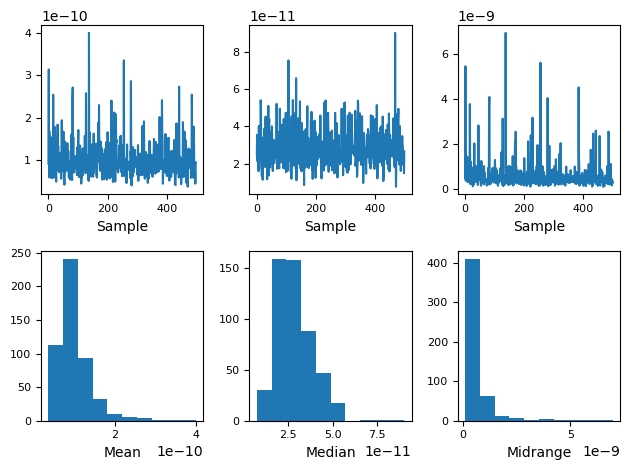

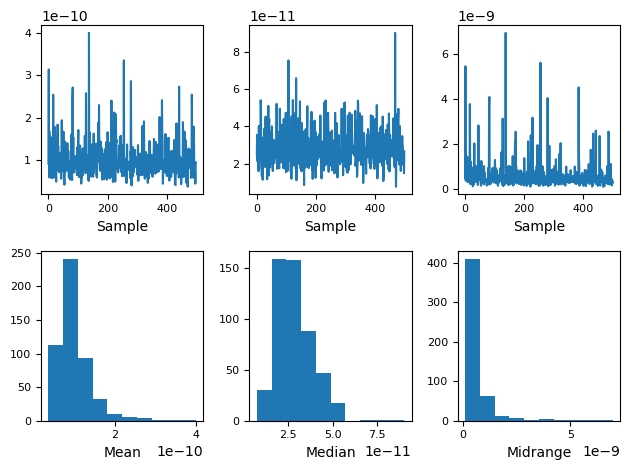

In [60]:
pd.plotting.bootstrap_plot(df2.acc)  

In [65]:
from scipy.stats import bootstrap
res = bootstrap((df2.acc,), np.mean, confidence_level=0.9)
res

MemoryError: Unable to allocate 141. GiB for an array with shape (9999, 1896241) and data type int64

In [63]:
np.array(df2.acc)

array([1.862957288494188e-12, 6.917063118124158e-13,
       5.326122053132873e-13, ..., 7.0388783052497715e-12,
       8.260074050550499e-13, 6.215358528165532e-13], dtype=object)

In [66]:
cluster.close()